1. WISDM dataset
Sitting 4500
Jogging 4500
2개만 뽑음

sitting 과 Jogging을 traing과 test로 나누고

3. activiteds -> labels
Sitting -> 0  (normal)
jogging -> 1  (abnormal)


In [1]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
from keras import regularizers
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42

In [3]:
df = pd.read_csv("./data/WISDM.csv")

df = df.drop(['Unnamed: 0', 'user-id', 'timestamp'], axis=1)

In [4]:
df

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098198,Sitting,9.000000,-1.570000,1.690000
1098199,Sitting,9.040000,-1.460000,1.730000
1098200,Sitting,9.080000,-1.380000,1.690000
1098201,Sitting,9.000000,-1.460000,1.730000


In [5]:
Jogging = df[df['activity']=='Jogging'].head(4500).copy()

In [6]:
Jogging

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
13015,Jogging,5.434519,8.853226,3.909040
13016,Jogging,-4.331271,19.531578,-1.729784
13017,Jogging,-1.035146,-5.012288,-4.481094
13018,Jogging,7.082581,17.243360,-0.381370


In [7]:
Sitting = df[df['activity']=='Sitting'].head(4499).copy()

In [8]:
balanced_data = pd.DataFrame()

balanced_data = pd.concat([balanced_data, Jogging, Sitting])

balanced_data.shape

(8999, 4)

In [9]:
balanced_data

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
255293,Sitting,-4.290000,-2.220000,8.308413
255294,Sitting,-4.330000,-2.180000,8.308413
255295,Sitting,-4.370000,-2.220000,8.349273
255296,Sitting,-4.290000,-2.220000,8.308413


In [10]:
balanced_data['X'] = (balanced_data['X']-balanced_data['X'].min())/(balanced_data['X'].max()-balanced_data['X'].min())
balanced_data['Y'] = (balanced_data['Y']-balanced_data['Y'].min())/(balanced_data['Y'].max()-balanced_data['Y'].min())
balanced_data['Z'] = (balanced_data['Z']-balanced_data['Z'].min())/(balanced_data['Z'].max()-balanced_data['Z'].min())
balanced_data

,activity,X,Y,Z
0,Jogging,0.410987,0.791254,0.497158
1,Jogging,0.584056,0.748350,0.511587
2,Jogging,0.580752,0.736799,0.478356
3,Jogging,0.413465,0.967409,0.578050
4,Jogging,0.396117,0.773927,0.712287
...,...,...,...,...
255293,Sitting,0.301954,0.339938,0.747704
255294,Sitting,0.300741,0.341149,0.747704
255295,Sitting,0.299528,0.339938,0.749016
255296,Sitting,0.301954,0.339938,0.747704


In [11]:
balanced_data['activity'].value_counts()

Jogging    4500
Sitting    4499
Name: activity, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

balanced_data['activity']=le.fit_transform(balanced_data['activity'])

In [13]:
balanced_data['activity'].value_counts()

0    4500
1    4499
Name: activity, dtype: int64

In [14]:
balanced_data

,activity,X,Y,Z
0,0,0.410987,0.791254,0.497158
1,0,0.584056,0.748350,0.511587
2,0,0.580752,0.736799,0.478356
3,0,0.413465,0.967409,0.578050
4,0,0.396117,0.773927,0.712287
...,...,...,...,...
255293,1,0.301954,0.339938,0.747704
255294,1,0.300741,0.341149,0.747704
255295,1,0.299528,0.339938,0.749016
255296,1,0.301954,0.339938,0.747704


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(balanced_data, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((6749, 4), (2250, 4))

In [16]:
# Normal = 0 Fall = 1

normal = X_train[X_train['activity'] == 0]
y_train = normal['activity']

X_train_normal_train = normal.drop(['activity'], axis=1)
X_train_ft = X_train_normal_train.values

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_test = X_test.values

In [17]:
X_train_ft.shape, X_test.shape, y_train.shape, y_test.shape

((3400, 3), (2250, 3), (3400,), (2250,))

In [18]:
noise_factor = 0.50

X_train_AE_noisy = X_train_ft.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_ft.shape)

X_test_AE_noisy = X_test.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [19]:
X_train_AE_noisy.shape, X_test_AE_noisy.shape, y_train.shape, y_test.shape

((3400, 3), (2250, 3), (3400,), (2250,))

In [29]:
input_dim = X_train_ft.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim, ))

encoder = Dense(input_dim, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(16), activation="relu")(encoder)
encoder = Dense(int(8), activation="relu")(encoder)
decoder = Dense(int(8), activation='relu')(encoder)
decoder = Dense(int(16), activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [76]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train_AE_noisy, X_train_AE_noisy,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.1348 - accuracy: 0.6716 - val_loss: 0.1269 - val_accuracy: 0.6794
Epoch 2/10
96/96 [==============================] - 0s 3ms/step - loss: 0.1145 - accuracy: 0.6902 - val_loss: 0.1116 - val_accuracy: 0.6971
Epoch 3/10
96/96 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.7373 - val_loss: 0.0924 - val_accuracy: 0.7735
Epoch 4/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0806 - accuracy: 0.8477 - val_loss: 0.0770 - val_accuracy: 0.8971
Epoch 5/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9271 - val_loss: 0.0697 - val_accuracy: 0.9382
Epoch 6/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.9490 - val_loss: 0.0663 - val_accuracy: 0.9500
Epoch 7/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 0.9585 - val_loss: 0.0645 - val_accuracy: 0.9588
Epoch 8/10
96/96 [==

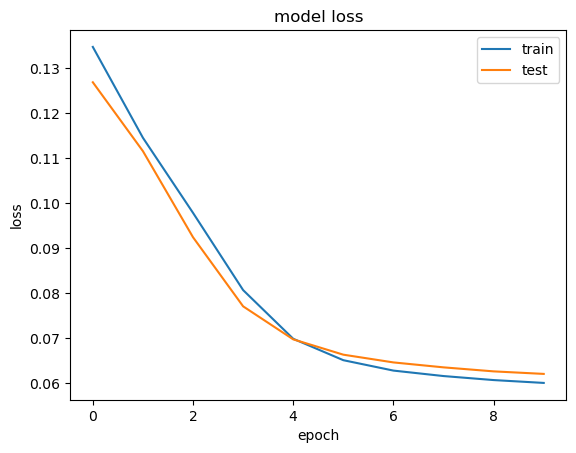

In [77]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');


In [78]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 1ms/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,0.002590,0.511111
std,0.001787,0.499988
min,0.000080,0.000000
25%,0.000855,0.000000
50%,0.002034,1.000000
75%,0.005156,1.000000
max,0.005410,1.000000


In [79]:
from sklearn.metrics import confusion_matrix

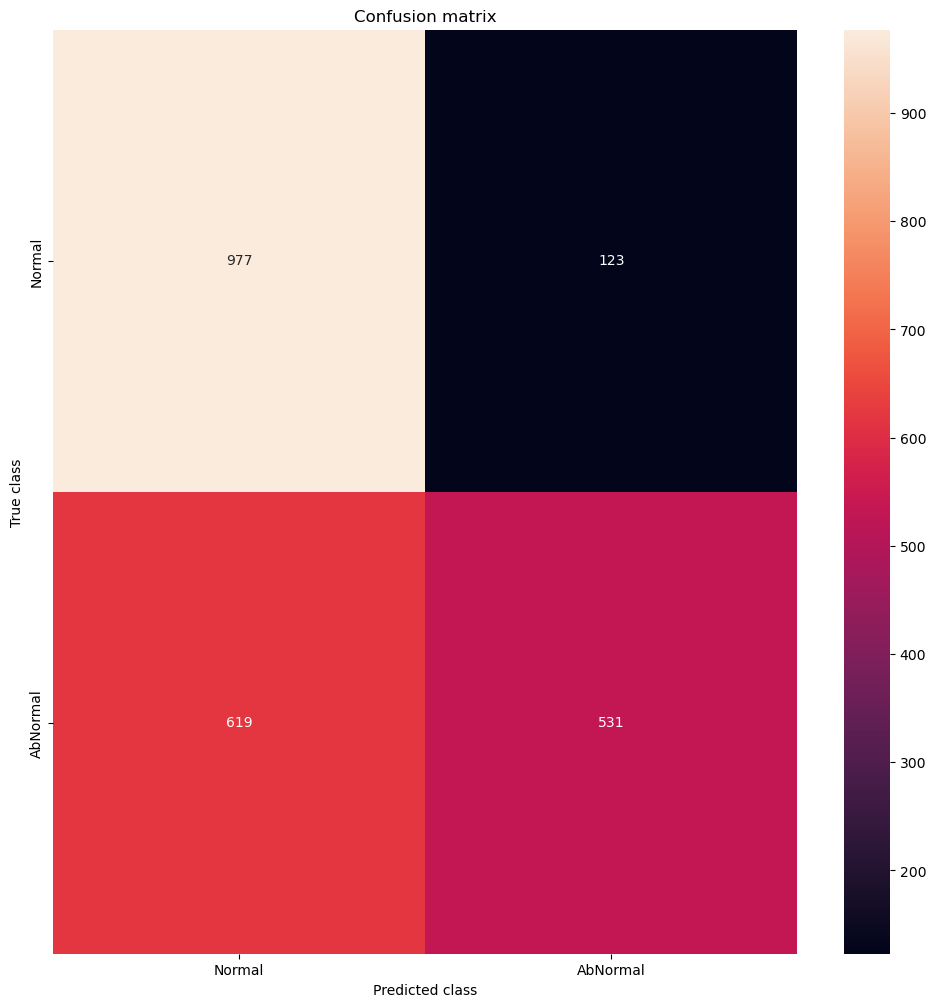

In [113]:
LABELS = ["Normal", "AbNormal"]
threshold = 0.00091


y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [114]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.6702222222222223
Precision : 0.8119266055045872
Recall : 0.4617391304347826
F1 : 0.5886917960088691
